# Data Science: Coursework 2

### Shri Lekkala
### CID: 01499487

### Table of Contents

* [Task 1](#t1) 
    * [Question 1.1](#q1_1)
        * [Part 1.1.1](#1_1_1)
        * [Part 1.1.2](#1_1_2)
        * [Part 1.1.3](#1_1_3)
    * [Question 1.2](#q1_2)
        * [Part 1.2.1](#1_2_1)
        * [Part 1.2.2](#1_2_2)
        * [Part 1.2.3](#1_2_3)
        * [Part 1.2.4](#1_2_4)
* [Task 2](#t2)
    * [Question 2.1](#q2_1)
        * [Part 2.1.1](#2_1_1)
        * [Part 2.1.2](#2_1_2)
        * [Part 2.1.3](#2_1_3)
    * [Question 2.2](#q2_2)
        * [Part 2.2.1](#2_2_1)
        * [Part 2.2.2](#2_2_2)
    * [Question 2.3](#q2_3)
        * [Part 2.3.1](#2_3_1)
        * [Part 2.3.2](#2_3_2)
        * [Part 2.3.3](#2_3_3)

In [1]:
# Import modules used throughout the coursework
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.sparse import linalg
import pandas as pd
import time
import csv
import collections
import seaborn as sns
import networkx as nx

# Set a random seed to fix the results
np.random.seed(1024)

## Task 1: Neural Networks <a class="anchor" id="t1"></a>
***

### 1.1 Multi-Layer Perceptron <a class="anchor" id="q1_1"></a>
***

#### Question 1.1.1 <a class="anchor" id="1_1_1"></a>
***

First we load the dataset:\
(We note that the x values are divided by 255 to normalize the input values to be between 0 and 1.)

In [2]:
def load_data ():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()

We can check the shapes of each of the relevant datasets:

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


We process the data into numpy arrays for use in this section:

In [4]:
# Convert the data into 2D numpy arrays
X_train_np = np.reshape(np.array(x_train), (50000, 3072), order='C').T
X_test_np = np.reshape(np.array(x_val), (10000, 3072), order='C').T
y_train_np = np.array(y_train).T
y_test_np = np.array(y_val).T

# Convert the one-hot vector of labels of 0s and 1s into an integer between 0 and 9
y_train_np_labels = np.argmax(y_train_np, axis = 0)
y_test_np_labels = np.argmax(y_test_np, axis = 0)

Once again we can check their shapes:

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


To get an idea of the outputs, we can add the list of label names corresponding to each class of the output, and  plot a randomly selected example from each class:

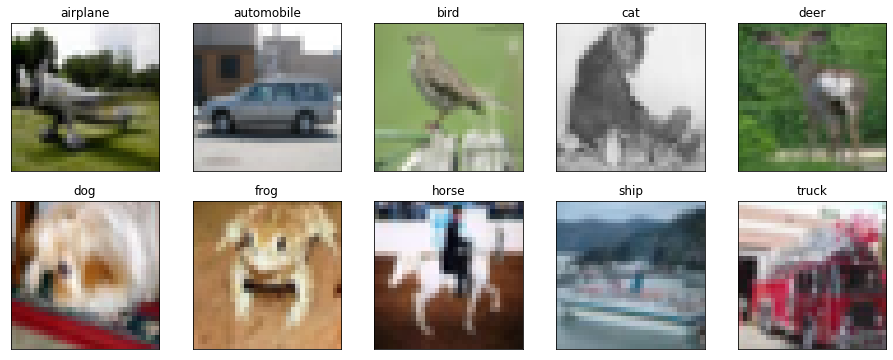

In [6]:
# Load the list of label names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot a randomly selected example from each class
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for l, label_name in enumerate(classes):
    row = l // n_cols
    col = l % n_cols
        
    inx = np.where(y_train_np_labels == l)[0]
    i = np.random.choice(inx)
    x_example = x_train[i]
    
    axes[row, col].imshow(x_example)
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].set_title(label_name)

plt.show()

First we create a function to randomly split the training dataset into batches of 128.

50,000 datapoints means that there will be 391 batches in total.\
Note here we make the final batch also size 128 by including some datapoints from the first batch.

In [7]:
def databatch(batch_size, x_data, y_data):
    n = x_data.shape[0]
    indices = np.arange(n)
    
    # shuffle before each epoch
    np.random.shuffle(indices)
    x_data = x_data[indices]
    y_data = y_data[indices]
    
    batches = [(x_data[k:k+batch_size], y_data[k:k+batch_size]) for k in range(0, n, batch_size)]
    
    # make the last batch the same size as the others by including elements from the start
    k = range(0, 50000, 128)[-1]
    last_batch_x = np.array([x_data[i%n] for i in range(k, k+batch_size)])
    last_batch_y = np.array([y_data[i%n] for i in range(k, k+batch_size)])
    
    batches[-1] = (last_batch_x, last_batch_y)
    
    return batches 

Next we create activation functions for the forward pass in the MLP, and also the derivative of the tanh activation dunction for use in backward pass:

In [8]:
def Tanh(h):
    return np.tanh(h)

def SoftMax(X):
    prob = np.exp(X) /np.sum(np.exp(X), axis=0)
    return prob

def dTanh(a1):
    # Note the derivative of tanh(x) is 1 - tanh^2(x)
    return 1 - np.square(np.tanh(a1))

We also have a function to compute the Cross Entropy Loss, using the formula 

$$ CE = - \sum t_i \log(f(s)_i) $$ where $\mathbf{t}$ is the one-hot truth vector, and $\mathbf{f(s)}$ is the output from the SoftMax activation layer.

In [9]:
def CrossEntropyLoss(y_truth, y_hat_softmax):
    ce_loss = - np.sum(y_truth * np.log(y_hat_softmax)) / y_truth.shape[1]
    return ce_loss

We also create a function for the dense layers to obtain the pre-activation values, and also a function to compute the output_error for use in back propagation:

In [10]:
def dense(h, W, b):
    return b + W @ h

def output_error(y_batch, a6):
    return a6 - y_batch

Throughout this section, I will be using the same notation as defined in the lectures:

Pre-activations: $\mathbf{a}^{(k)} + \mathbf{W}^{(k-1)} \mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} $ \
Post-activations: $\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}) $

In the code, I store all the relevant parameters in python dictionaries for easy access.\
In particular the pre and post activations of each layer are stored in the dictionary 'activations'\
The weights and biases of the layers are stored in the dictionary 'parameters'\
The relevant gradients for each layer are stored in the dictionary 'gradient'

First we create the function to compute the forward pass, and keep a record of all the pre and post activations in the dictionary:

In [11]:
def forward_pass(X, parameters):
    # create a dictionary to store the pre and post activations
    activations = {}
    
    # Five Hidden Layers
    activations['a1'] = dense(X, parameters['W0'], parameters['b0'])
    activations['h1'] = Tanh(activations['a1'])
    
    activations['a2'] = dense(activations['h1'], parameters['W1'], parameters['b1'])
    activations['h2'] = Tanh(activations['a2'])
    
    activations['a3'] = dense(activations['h2'], parameters['W2'], parameters['b2'])
    activations['h3'] = Tanh(activations['a3'])
    
    activations['a4'] = dense(activations['h3'], parameters['W3'], parameters['b3'])
    activations['h4'] = Tanh(activations['a4'])
    
    activations['a5'] = dense(activations['h4'], parameters['W4'], parameters['b4'])
    activations['h5'] = Tanh(activations['a5'])
    
    # Output Layer
    activations['a6'] = dense(activations['h5'], parameters['W5'], parameters['b5'])
    activations['h6'] = SoftMax(activations['a6'])
    
    return activations

Next, we have a function to compute all the required gradients by back propagation using the pre and post activations obtained from the function above.

We use the rules derived from the lectures:

$\Large{\boldsymbol{\delta_p}^{(k)} := \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k)}}}$

$\Large{\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W_{pq}}^{(k)}} = \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k+1)}} \cdot h_q^{k}}$

$\Large{\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b_p}^{(k)}} = \frac{\partial\mathcal{L}_i}{\partial \boldsymbol{a_p}^{(k+1)}}}$


Note that we also sum the vector of gradients and divide by the number of datapoints in the batch to get an average value over the batch size.

In [12]:
def back_propagate(X, y, activations, parameters):
    batch_size = X.shape[1]
    
    # create a dictionary to store the gradients
    gradient = {}
    
    gradient['delta6'] = output_error(y, activations['h6'])
    gradient['d_W5'] = gradient['delta6'] @ activations['h5'].T / batch_size
    gradient['d_b5'] = np.sum(gradient['delta6'], axis=1, keepdims=True) / batch_size
    
    gradient['delta5'] = dTanh(activations['a5']) * (parameters['W5'].T @ gradient['delta6'])
    gradient['d_W4'] = gradient['delta5'] @ activations['h4'].T / batch_size
    gradient['d_b4'] = np.sum(gradient['delta5'], axis=1, keepdims=True) / batch_size
    
    gradient['delta4'] = dTanh(activations['a4']) * (parameters['W4'].T @ gradient['delta5'])
    gradient['d_W3'] = gradient['delta4'] @ activations['h3'].T / batch_size
    gradient['d_b3'] = np.sum(gradient['delta4'], axis=1, keepdims=True) / batch_size
    
    gradient['delta3'] = dTanh(activations['a3']) * (parameters['W3'].T @ gradient['delta4'])
    gradient['d_W2'] = gradient['delta3'] @ activations['h2'].T / batch_size
    gradient['d_b2'] = np.sum(gradient['delta3'], axis=1, keepdims=True) / batch_size
    
    gradient['delta2'] = dTanh(activations['a2']) * (parameters['W2'].T @ gradient['delta3'])
    gradient['d_W1'] = gradient['delta2'] @ activations['h1'].T / batch_size
    gradient['d_b1'] = np.sum(gradient['delta2'], axis=1, keepdims=True) / batch_size
    
    gradient['delta1'] = dTanh(activations['a1']) * (parameters['W1'].T @ gradient['delta2'])
    gradient['d_W0'] = gradient['delta1'] @ X.T / batch_size
    gradient['d_b0'] = np.sum(gradient['delta1']) / batch_size

    return gradient

Once we have the all the gradient terms, we can then use stochastic gradient descent to update our parameter values of weights and biases in the direction of the negative gradient with a specified learning rate.

For a general parameter $\theta$, learning rate $\eta$, loss function $L$, mini-batch $\mathcal{D}_m$ and iteration $t$ the update rule is: $\theta_{t+1} = \theta_t - \eta \Delta_{\theta} L (\theta_t; \mathcal{D}_m)$

This function computes these new parameter values and updates the values in the dictionary:

In [13]:
def SGD_optimize(parameters, gradient, learning_rate):
    parameters['W5'] -= learning_rate * gradient['d_W5']
    parameters['b5'] -= learning_rate * gradient['d_b5']
    
    parameters['W4'] -= learning_rate * gradient['d_W4']
    parameters['b4'] -= learning_rate * gradient['d_b4']

    parameters['W3'] -= learning_rate * gradient['d_W3']
    parameters['b3'] -= learning_rate * gradient['d_b3']
    
    parameters['W2'] -= learning_rate * gradient['d_W2']
    parameters['b2'] -= learning_rate * gradient['d_b2']
    
    parameters['W1'] -= learning_rate * gradient['d_W1']
    parameters['b1'] -= learning_rate * gradient['d_b1']
    
    parameters['W0'] -= learning_rate * gradient['d_W0']
    parameters['b0'] -= learning_rate * gradient['d_b0']
    
    return parameters

Finally we have a function that classifies a set of data points $X$ given $X$ and the parameters (weights and biases) of the MLP model by passing through all the dense and activation layers.

The output from the SoftMax layer, h6, is converted into a vector of labels by using argmax. \
However we return both the predictions and h6 in order to compute accuracies and losses respectively.

In [14]:
def get_preds(X, parameters):
    a1 = dense(X, parameters['W0'], parameters['b0'])
    h1 = Tanh(a1)
    
    a2 = dense(h1, parameters['W1'], parameters['b1'])
    h2 = Tanh(a2)
    
    a3 = dense(h2, parameters['W2'], parameters['b2'])
    h3 = Tanh(a3)
    
    a4 = dense(h3, parameters['W3'], parameters['b3'])
    h4 = Tanh(a4)
    
    a5 = dense(h4, parameters['W4'], parameters['b4'])
    h5 = Tanh(a5)
    
    a6 = dense(h5, parameters['W5'], parameters['b5'])
    h6 = SoftMax(a6)
    
    preds = np.argmax(h6, axis=0)
    return h6, preds

Next we have a function to randomly intialise a set of weights to be used at the beginning of model training. The biases are intialised as zero vectors.

The dimensions of the arrays for each parameter depends on the number of neurons in the previous layer and the number of neurons in the next layer.

In [15]:
def initial_parameters(num_h, D):
    # num_h: Number of Neurons in hidden layer
    # D: Number of neurons in layer 0 (Number of inputs)
    # The number of neurons in the last layer (output layer) is fixed at 10
    parameters = {'W0': np.random.randn(num_h, D) * 0.05,
                  'b0': np.zeros((num_h, 1)),
                  
                  'W1': np.random.randn(num_h, num_h) * 0.05,
                  'b1': np.zeros((num_h, 1)),
                    
                  'W2': np.random.randn(num_h, num_h) * 0.05,
                  'b2': np.zeros((num_h, 1)),
                     
                  'W3': np.random.randn(num_h, num_h) * 0.05,
                  'b3': np.zeros((num_h, 1)),
                     
                  'W4': np.random.randn(num_h, num_h) * 0.05,
                  'b4': np.zeros((num_h, 1)),
                     
                  'W5': np.random.randn(10, num_h) * 0.05,
                  'b5': np.zeros((10, 1))}
    
    return parameters

Finally we can create an overall function to train the MLP as required by using all the functions above.

The inputs are the hyperparameters: number of epochs and learning rate.\
The outputs are dictionaries containing the metrics for this model: training & validation losses, training & validation accuracies, total training time.

In [16]:
def MLP(num_epochs, l_rate):
    start = time.time()
    
    # Create lists to store accuracies and losses over the epochs
    Accuracies = []
    Losses = []

    # Set the number of neurons per hidden layer
    num_h = 400
    
    # Get the initialised set of parameters
    Params = initial_parameters(num_h, X_train_np.shape[0])
    
    ## Loop over the epochs
    for i in range(num_epochs):
        
        # Obtain new randomly sampled batches for each epoch
        # (This will return 391 batches of 128 to cover all the 50,000 data points)
        batches = databatch(128, X_train_np.T, y_train_np.T)
        
        # Loop over each batch
        for x_batch, y_batch in batches:
            X = x_batch.T
            y = y_batch.T
        
            # Compute all the pre and post activations in the Forward Pass
            forwardPass = forward_pass(X, Params)
            
            # Back Propagate to find the gradients
            gradient = back_propagate(X, y, forwardPass, Params)
        
            # Update the parameters according to Stochastic Gradient Descent
            Params = SGD_optimize(Params, gradient, l_rate)
        
        # Obtain the predictions and softmax outputs using the model for the training and validation sets
        y_train_softmax, y_train_hat = get_preds(X_train_np, Params)
        y_val_softmax, y_val_hat = get_preds(X_test_np, Params)
        
        # Compute the percentage accuracies
        train_acc = np.sum(y_train_hat == y_train_np_labels) / len(y_train_np_labels)
        val_acc = np.sum(y_val_hat == y_test_np_labels) / len(y_test_np_labels)
        
        # Compute the losses
        train_loss = CrossEntropyLoss(y_train_np, y_train_softmax)
        val_loss = CrossEntropyLoss(y_test_np, y_val_softmax)
        
        # Store the the metrics in the lists
        Losses.append((train_loss, val_loss))
        Accuracies.append(((train_acc, val_acc)))
        
        # Print the progress
        if i%5 == 4:
            print("Epoch " + str(i+1) + "/ " + str(num_epochs))
    
    # Calculate the time taken
    time_diff = time.time() - start
    train_time = time.strftime("%H:%M:%S", time.gmtime(time_diff))
    
    # Return the metrics and predictions
    return Losses, Accuracies, train_time, y_train_softmax, y_val_softmax

As required we train this MLP on batches of 128 datapoints with a learning rate of 0.01 for 40 epochs.\
The metrics obtained are stored in a dictionary.

In [17]:
MLP_Metrics = {}
MLP_Metrics["40, 0.01"] = MLP(40, 0.01)

Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40


In [18]:
print("Final Validation Loss           :", MLP_Metrics["40, 0.01"][0][-1][1])
print('Final Validation Accuracy       :', MLP_Metrics["40, 0.01"][1][-1][1])
print('Total Training Time             :', MLP_Metrics["40, 0.01"][2])

Final Validation Loss           : 1.3395225844556653
Final Validation Accuracy       : 0.5235
Total Training Time             : 00:12:27


We then create a function to create plots from the metrics we obtained:

In [19]:
def MLP_plots(num_epochs, l_rate):
    key = str(num_epochs) + ', ' + str(l_rate)
    
    # Obtain the metrics
    train_loss = np.array(MLP_Metrics[key][0])[:, 0]
    val_loss = np.array(MLP_Metrics[key][0])[:, 1]
    train_acc = np.array(MLP_Metrics[key][1])[:, 0]
    val_acc = np.array(MLP_Metrics[key][1])[:, 1]
    
    # Plot the metrics
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    x_axis = np.arange(num_epochs) + 1
    ax0.set_title("Cross-Entropy Loss vs Number of Epochs, [Learning Rate = " + str(l_rate) + "]")
    ax0.plot(x_axis, train_loss, label = "Training Set")
    ax0.plot(x_axis, val_loss, label = "Validation Set")
    ax0.legend()
    ax0.grid()
    ax0.set_xlabel("Epoch Number")
    ax0.set_ylabel("Loss")
    
    ax1.set_title("Accuracy vs Number of Epochs [Learning Rate = " + str(l_rate) + "]")
    ax1.plot(x_axis, train_acc, label = "Training Set")
    ax1.plot(x_axis, val_acc, label = "Validation Set")
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Accuracy")
    plt.show()
    return

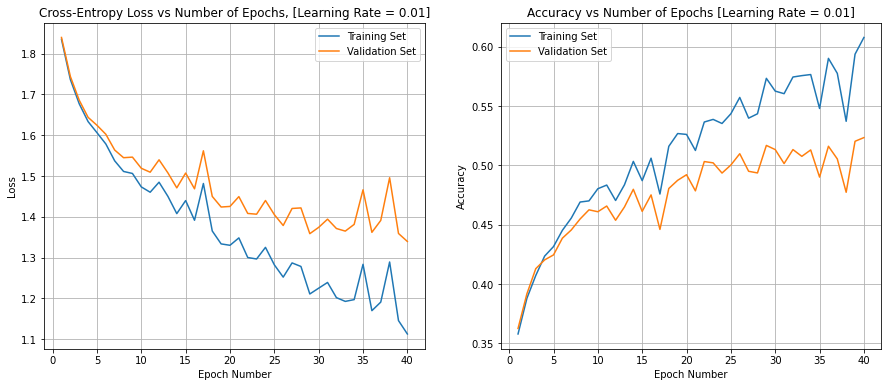

In [20]:
MLP_plots(40, 0.01)

Firstly we notice that as the number of epochs increases, the general trend is that the percentage accuracy increases whilst the loss decreases.

The loss and accuracies start of the same for both the training and validation sets, however we observe that the gap between them increases with the number of epochs. The model performs better for the training set than the validation one in the long run, and this is expected as the model is trained only using the training set.

However we can note that the curves are not smooth, instead they have spikes where the model can perform slightly worse on the next iteration. This might be explained by the fact that we are using stochastic gradient descent as our optimizer. As this involves taking a sample of datapoints, this means we only have a noisy estimate of the true gradient,and so in some iterations, the gradient found might be in the direction of a local minimum of the loss function but not a global minimum that we require.

Also whilst the accuracy curves start to increase more slowly with a greater number of epochs, they do not significantly decrease beyond the trend which suggests that overfitting has not yet occured.

#### Question 1.1.2 <a class="anchor" id="1_1_2"></a>
***

We use the same functions above to train the MLP with different learning rates:

In [21]:
MLP_Metrics["40, 0.0001"] = MLP(40, 0.0001)
print('Total Training Time  : ', MLP_Metrics["40, 0.0001"][2])
print(' ')

MLP_Metrics["40, 0.1"] = MLP(40, 0.1)
print('Total Training Time  : ', MLP_Metrics["40, 0.1"][2])

Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40
Total Training Time  :  00:13:02
 
Epoch 5/ 40
Epoch 10/ 40
Epoch 15/ 40
Epoch 20/ 40
Epoch 25/ 40
Epoch 30/ 40
Epoch 35/ 40
Epoch 40/ 40
Total Training Time  :  00:12:42


The plots obtained are:

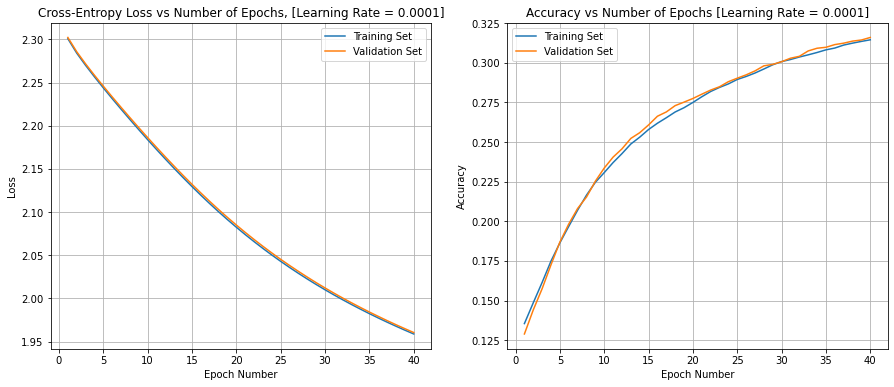

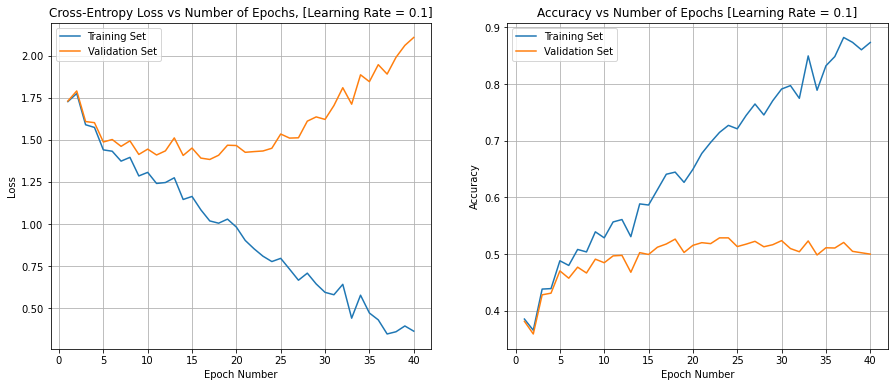

In [22]:
MLP_plots(40, 0.0001)
MLP_plots(40, 0.1)

Firstly we observe that changing the learning rate has a great effect on the behaviour of the model.

With a very small learning rate of 0.0001, we observe very smooth curves for both the loss and the accuracy, and the curves for the training and validation sets are almost overlapping.\
Furthermore, the curves are strictly monotonic so overfitting does not appear to have occured yet.

This can be explained by the fact that the learning rate is the step size used in stochastic gradient descent. So with a very small learning rate, the model will be less likely to "jump over" a local minima of a loss function and cause the loss to increase again.

On the other hand, with a larger learning rate of 0.1, we see that the curves are much more jagged, and also whilst the training set has a generally decreasing loss, the validation set has a loss curve that increases again after a global minimum approximately at Epoch 20. The validation accuracy curve also seems to level off, and not increase after about 20 epochs.

This does suggest that overfitting has occured, since the final model performs very well for the training set (accuracy of nearly 0.9), but the final validation accuracy is around 0.5. The jagged shape can be explained by the fact that with a high learning rate, the model can overshoot beyond the minima of the loss function.

When comparing the final validation accuracies, we see that it is around 0.3 for a learning rate of 0.0001 and 0.5 for a learning rate of 0.1. Thus in the latter model, even though overfitting has occured it performs better than the former model. So too small of a learning rate means that the convergence of the model is too slow and will require a greater number of epochs (and thus more computational power) to get similar results to that of a higher learning rate.

#### Question 1.1.3 <a class="anchor" id="1_1_3"></a>
***

Finally we train the MLP over 80 epochs with the learning rate 0.01 and again plot the metrics:

In [23]:
MLP_Metrics["80, 0.01"] = MLP(80, 0.01)
print('Total Training Time  : ', MLP_Metrics["80, 0.01"][2])

Epoch 5/ 80
Epoch 10/ 80
Epoch 15/ 80
Epoch 20/ 80
Epoch 25/ 80
Epoch 30/ 80
Epoch 35/ 80
Epoch 40/ 80
Epoch 45/ 80
Epoch 50/ 80
Epoch 55/ 80
Epoch 60/ 80
Epoch 65/ 80
Epoch 70/ 80
Epoch 75/ 80
Epoch 80/ 80
Total Training Time  :  00:24:21


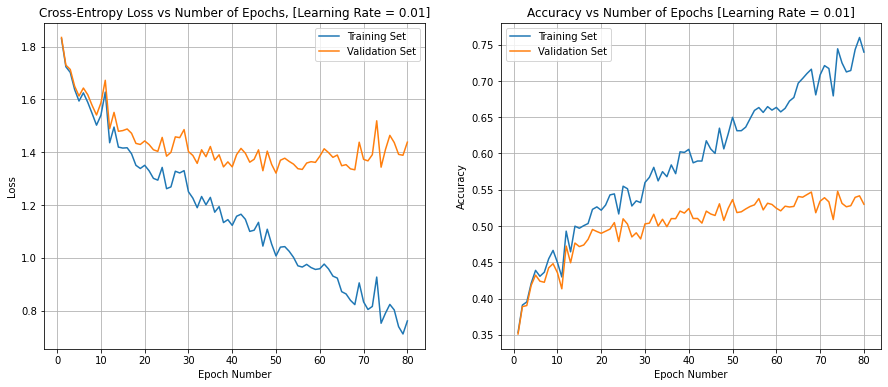

In [24]:
MLP_plots(80, 0.01)

Firstly we observe that the loss and accuracy curves are very similar to those in 1.1.1, however the gap between the training set curves and the validation set curves get much larger.\
This is expected as the model is only exposed to the training set whilst training, so as the model performs better and better for the training set, overfitting will start to occur as the model may pick up on features that only exist in the training sample but not the validation sample.

The final performance of the four models are summarised below:

In [25]:
def get_last_metrics(metric_list):
    final_loss = list(metric_list[0][-1])
    final_accuracy = list(metric_list[1][-1])
    train_time = str(metric_list[2])
    return final_loss + final_accuracy + [train_time]

MLP_comparison = pd.DataFrame(columns=['Training Loss', 'Validation Loss',
                                       'Training Accuracy', 'Validation Accuracy','Training Time'],
                              index=['40 Epochs, $\eta$ = 0.0001', '40 Epochs, $\;\;\: \eta$ = 0.01',
                                     '40 Epochs, $\quad\; \eta$ = 0.1', '80 Epochs, $\;\;\: \eta$ = 0.01'],
                              data = [get_last_metrics(MLP_Metrics["40, 0.0001"]),
                                               get_last_metrics(MLP_Metrics["40, 0.01"]),
                                               get_last_metrics(MLP_Metrics["40, 0.1"]),
                                               get_last_metrics(MLP_Metrics["80, 0.01"])])

MLP_comparison

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Training Time
"40 Epochs, $\eta$ = 0.0001",1.958748,1.960408,0.31452,0.3160,00:13:02
"40 Epochs, $\;\;\: \eta$ = 0.01",1.112760,1.339523,0.60792,0.5235,00:12:27
"40 Epochs, $\quad\; \eta$ = 0.1",0.364331,2.107396,0.87338,0.4999,00:12:42
"80 Epochs, $\;\;\: \eta$ = 0.01",0.761000,1.437788,0.73982,0.5300,00:24:21


We see that the "best" model in terms of validation accuracy is the one for 80 epochs and a learning rate of 0.01, however this is only marginally higher than that of 40 epochs, but it takes almost twice as long in computational time.

This suggests that the validation accuracy for the 80 epochs model has levelled off, and this is apparent in the graph above where it sharply increases, but stays approximately the same after about 40 epochs. However the training accuracy keeps increasing, so after a certain number of epochs, the model will learn features only specific to that training set sample of datapoints, and so will not necessarily improve when evaluated against the validation set.

The learning rates also seem to have a great effect on the final validation accuracy.\
As explained above, the update rule in stochastic gradient descent is: $\theta_{t+1} = \theta_t - \eta \Delta_{\theta} L (\theta_t; \mathcal{D}_m)$

So $\eta = 0.0001$ is too small and the small step size results in slow convergence to the minimum of the loss function, on the other hand $\eta = 0.1$ is too large and quickly converges to a local minimum of the loss function, but the does not learn enough features so the model results in overfitting. For this $\eta$ the training loss is the lowest of the models, but the validation loss is the highest. So it is clear that careful combination of hyperparameters is required to get the optimal model.

Furthermore, in all the models above, we have not implemented any form of regularisation.\
This is important as 5  hidden layers with 400 neurons each results in a very complex model with many parameters which can be prone to overfitting.

### 1.2 Convolutional Neural Network (CNN) <a class="anchor" id="q1_2"></a>
***

#### Question 1.2.1 <a class="anchor" id="1_2_1"></a>
***

First we process the data by loading it into tf.data.Dataset objects and batch them into batches of 128 data points as required:

In [26]:
# Dataset Objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Batching
batch_size = 128
train_dataset_batched = train_dataset.batch(batch_size)
val_dataset_batched = val_dataset.batch(batch_size)

# Check the shapes are as expected
train_dataset_batched.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

Now we can build the model according to the required architecture.

It should be noted that a Flatten layer is added in between the convolutional layers and the fully-connected (Dense) layers. This unrolls the dataset into a 1-dimensional object as the spatial structure is no longer used in the Dense layers.

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

model_1 = Sequential([
     Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     Dense(10, activation='softmax')])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

We also create a function to train the CNN model, in which we fix the optimisation to be SGD and use categorical cross-entropy as the loss function.\
The number of epochs and the learning rate are fixed at 40 and 0.1 respectively.\
There is an optional parameter to add callbacks which is used in latter parts.

In [28]:
def train_CNN(model, callback=None):
    start = time.time()
    
    # Define the Optimization method and Loss function
    sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    
    model.compile(optimizer=sgd, loss=loss_fn, metrics=['categorical_accuracy'])
    
    # Train the model using the training set (adding a callback if given)
    if callback:
        history = model.fit(train_dataset_batched, epochs=40, validation_data=val_dataset_batched, verbose=0,
                            callbacks = [callback])
    else:
        history = model.fit(train_dataset_batched, epochs=40, validation_data=val_dataset_batched, verbose=0)
    
    # Calculate the time taken
    time_diff = time.time() - start
    train_time = time.strftime("%H:%M:%S", time.gmtime(time_diff))
    
    # Return the metrics
    return history, train_time

We train the model by calling this function:

In [29]:
history_1, train_time_1 = train_CNN(model_1)
print('Total Training Time  : ', train_time_1)

Total Training Time  :  00:16:53


We also create a function to plot the losses and accuracies given the history of the model:

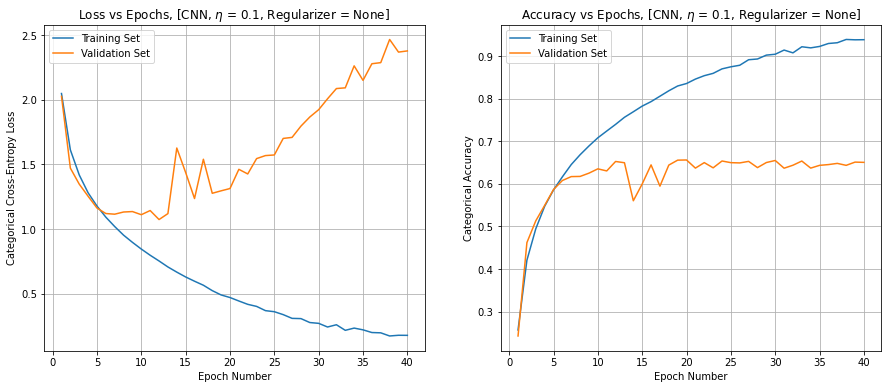

In [30]:
def CNN_plots(history, reg_info):
    # PLot of losses and accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    x_axis = np.arange(len(val_acc)) + 1
    ax0.set_title("Loss vs Epochs, " + 
                  "[CNN, $\eta$ = 0.1, Regularizer = " + reg_info + "]")
    ax0.plot(x_axis, train_loss, label = "Training Set")
    ax0.plot(x_axis, val_loss, label = "Validation Set")
    ax0.legend()
    ax0.grid()
    ax0.set_xlabel("Epoch Number")
    ax0.set_ylabel("Categorical Cross-Entropy Loss")
    
    ax1.set_title("Accuracy vs Epochs, " + 
                  "[CNN, $\eta$ = 0.1, Regularizer = " + reg_info + "]")
    ax1.plot(x_axis, train_acc, label = "Training Set")
    ax1.plot(x_axis, val_acc, label = "Validation Set")
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Categorical Accuracy")
    plt.show()
    
    return

CNN_plots(history_1, "None")

Firstly, we oberserve smooth curves for the loss and accuracy of the training set. The fact that these appear to be monotonic indicates that training is occuring as expected, with a final training accuracy of over 0.9 at Epoch 40.

On the other hand the validation set curves are much more jagged. For the loss, the curve appears to have a local minimum at around 10 epochs before increasing beyond the starting loss, and the validation accuracy seems to level off at around 0.65 from Epoch 10 onwards. \
The quickly increasing validation loss, whilst training loss is decreasing, does seem to suggest that overfitting may be occuring.

#### Question 1.2.2 <a class="anchor" id="1_2_2"></a>
***

Here we implement L2 regularisation (which is a form of weight regularisation) to the convolutional layers of the model.

In [31]:
from tensorflow.keras import regularizers

model_2 = Sequential([
     Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(5e-3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(5e-3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(5e-3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     Dense(10, activation='softmax')])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

Once again we train the model and plot the metrics:

In [32]:
history_2, train_time_2 = train_CNN(model_2)
print('Total Training Time  : ', train_time_2)

Total Training Time  :  00:17:29


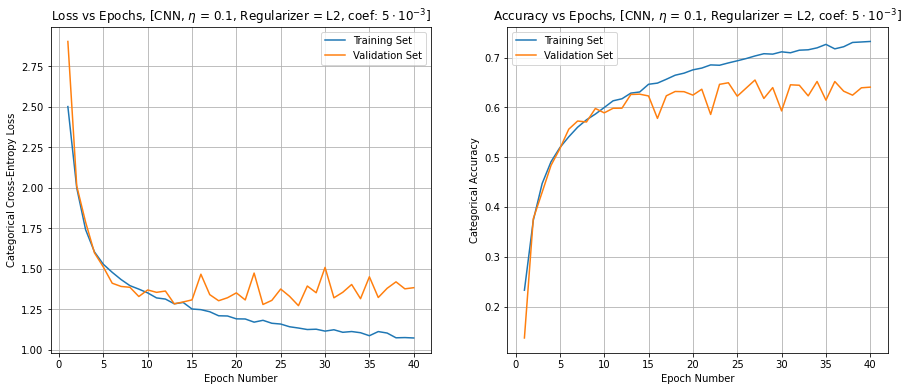

In [33]:
CNN_plots(history_2, "L2, coef: $5 \cdot 10^{-3}$")

With the added L2 regularisation, we observe that the difference between the training and validation curves is not as stark as before. Further, the general trend of the validation loss curve does not seem to be increasing, with the exception of a large spike at Epoch 22 which may just be due to the random element of the optimization method.

So we see that overfitting is less likely to be occuring here.\
Comparing the final accuracies, we see that the final final training accuracy is only around 0.7, compared to 0.9 previously, however the validation accuracies are in the same ballpark of approximately 0.65.

L2 regularisation adds a penalty term to the loss function which is a proportional to the sum of the square of the weight coefficients:
$$ \textrm{Loss} = \textrm{Cross-Entropy Loss} + \frac{\lambda}{2} \sum_j w_j^2$$
where $\lambda$ is the regularisation coefficient.
This ensures that the magnitudes of the weight terms do not get too large.

If we did not restrict this, the weights will be unbounded so they can grow in order to better identify the specific features in the training data. However this makes the model very prone to overfitting as the specific neural network might only be suited to the specific sample data in the training data, and hence the model will not be as generalisable.

#### Question 1.2.3 <a class="anchor" id="1_2_3"></a>
***

Firstly we implement Dropout with a rate of 0.5 to the model from 1.2.1.

In [34]:
from tensorflow.keras.layers import Dropout

model_3= Sequential([
     Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     # Dropout added Here
     Dropout(0.5),
     Dense(10, activation='softmax')])

In [35]:
history_3, train_time_3 = train_CNN(model_3)
print('Total Training Time  : ', train_time_3)

Total Training Time  :  00:17:46


Next we implement Early Stopping as an alternative method of weight regularisation.

In [36]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10)

model_4 = Sequential([
     Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     MaxPool2D((2, 2)),
     Conv2D(64, (3, 3), activation='relu'),
     Flatten(),
     Dense(64, activation='relu'),
     Dense(10, activation='softmax')])

In [37]:
history_4, train_time_4 = train_CNN(model_4, callback = earlystopping)
print('Total Training Time  : ', train_time_4)

Total Training Time  :  00:08:24


We then can see the plots for the model for the 2 regularisation methods below:

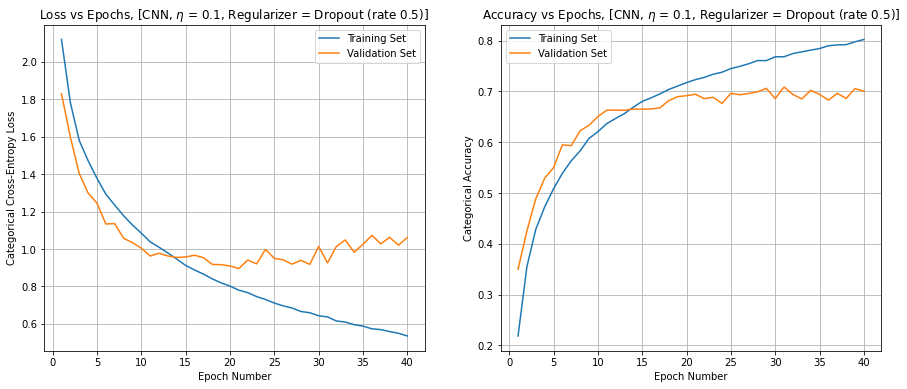

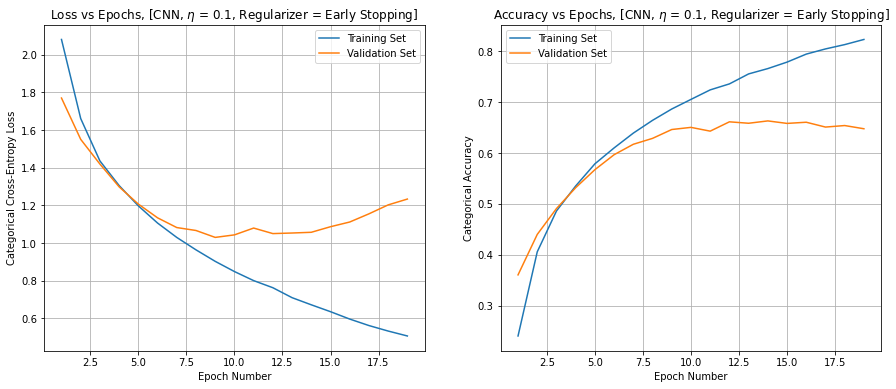

In [38]:
CNN_plots(history_3, "Dropout (rate 0.5)")

CNN_plots(history_4, "Early Stopping")

In terms of model performance, we observe that the final validation accuracy for the model with Dropout is just over 0.7, which is greater than the previous 2 CNN models above. Whereas the validation accuracy for the model with Early Stopping is similar to those above at around 0.65.

With both these regularisation methods, the training and validation curves seem to overlap before widening and creating a gap halfway through training.

Dropout:\
We used Dropout in between the two fully-connected (Dense) layers of the model.  This is because the effect of dropout is to randomly drop connections between two layers in a neural network to reduce interdependency in the hidden layers. So it would make sense to implement it between the layers with the most number of parameters that are likely to co-adapt and cause overfitting (i.e. in the Dense layers).

This does appear to be somewhat working as the final validation accuracy is higher than the previous 2 models. However it is only an increase in 0.05, we would need to experiment with adding multiple Dropout layers in different places and also changing the dropout probability rate. If we had more time and computational resources, we could use a grid search method to find the optimal Dropout parameters.

Early Stopping:\
In the case of Early Stopping, we chose to use validation loss as the metric to monitor. This regularisation method tracks the validation loss after each epoch, and stops the training of the model if the loss does not keep decreasing after a the "patience" threshold of epochs (here we set patience = 10). This has the effect of avoiding over-training the model to the training data, hence reducing overfitting.

We can immediately see the effect of this as the model has stopped training after only 21 Epochs, as the validation loss did not decrease beyond the value at the 11th Epoch. The final validation accuracy is approximately the same as that for the L2 regularisation model above. However it is not as high as the model with Dropout, which suggests that we may need to adjust the patience parameter to add some more leeway.

In the ideal scenario, we would implement a combination of the regularization methods mentioned above as they all serve slightly different roles and it is hard to compare them using only one specific model. However again finding the right balance of regularization methods and parameters to use is important as if we are too strict, underfitting might occur.

#### Question 1.2.4 <a class="anchor" id="1_2_4"></a>
***

First we can see the structure of the MLP model from 1.1.1 by building the model outline on tensorflow.\
We then retrieve the total number of parameters from both models of interest.

In [39]:
MLP_model = Sequential([
     Flatten(input_shape=(32, 32, 3)),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(400, activation='tanh'),
     Dense(10, activation='softmax')])

MLP_model.summary()
MLP_parameters = MLP_model.count_params()
CNN_parameters = model_3.count_params()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 400)               1229200   
_________________________________________________________________
dense_9 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_10 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_11 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_12 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

Now we can summarise the various performance metrics and model differences in the table below:

In [40]:
MLP_metrics_1 = get_last_metrics(MLP_Metrics["40, 0.01"]) + [MLP_parameters]

CNN_metrics = [history_3.history['loss'][-1],
               history_3.history['val_loss'][-1], 
               history_3.history['categorical_accuracy'][-1], 
               history_3.history['val_categorical_accuracy'][-1], 
               train_time_3,
               CNN_parameters]


NN_comparison = pd.DataFrame(columns=['Training Loss', 'Validation Loss',
                                       'Training Accuracy', 'Validation Accuracy',
                                       'Computational Time', 'Number of Parameters'],
                              index=['MLP: 40 Epochs, $\eta$ = 0.01', 'CNN: 40 Epochs, $\,\: \eta$ = 0.1'],
                              data = (MLP_metrics_1, CNN_metrics))

NN_comparison

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Computational Time,Number of Parameters
"MLP: 40 Epochs, $\eta$ = 0.01",1.112760,1.339523,0.60792,0.5235,00:12:27,1874810
"CNN: 40 Epochs, $\,\: \eta$ = 0.1",0.535186,1.061055,0.80240,0.7004,00:17:46,122570


We first observe that the performance of the CNN model is much better than that of the MLP model when judging by the validation accuracy, with an approximately 34% increase in accuracy.

It is also notable that the number of parameters for the MLP is more than 15 times greater than that for the CNN. Although having a greater number of model parameters allows for more flexibility, it also makes it more prone to overfitting to the training data. 

Furthermore, the CNN model makes up for the lack of parameters by introducing more model complexity between the hidden layers using the convolution operation. These are more computationally intensive tasks compared to the ones in the MLP and this is reflected by the increase in computation time for CNN despite having fewer parameters.

We can also get the plots of the two models on the same axes:

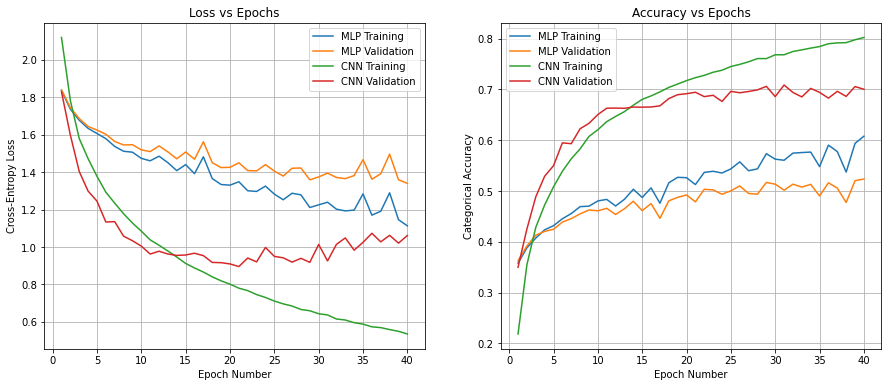

In [41]:
MLP_train_loss = np.array(MLP_Metrics["40, 0.01"][0])[:, 0]
MLP_val_loss = np.array(MLP_Metrics["40, 0.01"][0])[:, 1]
MLP_train_acc = np.array(MLP_Metrics["40, 0.01"][1])[:, 0]
MLP_val_lacc = np.array(MLP_Metrics["40, 0.01"][1])[:, 1]

CNN_train_loss = history_3.history['loss']
CNN_val_loss = history_3.history['val_loss']
CNN_train_acc = history_3.history['categorical_accuracy']
CNN_val_acc = history_3.history['val_categorical_accuracy']

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x_axis = np.arange(40) + 1
ax0.set_title("Loss vs Epochs")
ax0.plot(x_axis, MLP_train_loss, label = "MLP Training")
ax0.plot(x_axis, MLP_val_loss, label = "MLP Validation")
ax0.plot(x_axis, CNN_train_loss, label = "CNN Training")
ax0.plot(x_axis, CNN_val_loss, label = "CNN Validation")
ax0.legend()
ax0.grid()
ax0.set_xlabel("Epoch Number")
ax0.set_ylabel("Cross-Entropy Loss")

ax1.set_title("Accuracy vs Epochs")
ax1.plot(x_axis, MLP_train_acc, label = "MLP Training")
ax1.plot(x_axis, MLP_val_lacc, label = "MLP Validation")
ax1.plot(x_axis, CNN_train_acc, label = "CNN Training")
ax1.plot(x_axis, CNN_val_acc, label = "CNN Validation")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Epoch Number")
ax1.set_ylabel("Categorical Accuracy")
plt.show()

The CNN model metrics consistently appear to outperform their respective metrics for the MLP model beyond an initial few epochs.

It is also notable that the validation accuracy curve for the CNN model seems to well be above the training accuracy curve for the MLP model.

Once again these differences can be explained by the complex nature of the hidden layers in the CNN model. Furthermore we did not implement any regularisation in the MLP model, but we did include Dropout in the CNN model which further aids model training.

One thing to note is that we used different learning rates for stochastic gradient descent in the two models (0.01 for MLP and 0.1 for CNN), so a simple comparison between these two specific models might not be appropriate. If we wanted a more in depth comparison and had more computational resources, we would train both models over a range of different hyperparameters including learning rates, regularization methods and number of epochs.

Finally, we can also plot some example images from the validation set and see their categorical distributions as predicted by the two models:

In [42]:
def plot_examples(preds_1, preds_2, inx):
    # Obtain the categorical distributions of the predictions
    random_preds_1 = preds_1[random_inx, ...]
    random_preds_2 = preds_2[random_inx, ...]
    random_test_images = x_val[random_inx, ...]
    random_test_labels = y_test_np_labels[random_inx]
    
    # Create a 4x3 grid of subplots
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.6, wspace=0.2)
    
    for i, (prediction_1, prediction_2, image, label) in enumerate(zip(random_preds_1, random_preds_2, 
                                                                       random_test_images, random_test_labels)):
        # Example Images
        axes[i, 0].imshow(image)
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].set_title(f'{classes[label]}')
        
        # MLP Distributions
        axes[i, 1].bar(classes, prediction_1)
        axes[i, 1].set_xticks(np.arange(len(prediction_1)))
        axes[i, 1].set_title(f"MLP Model prediction: {classes[np.argmax(prediction_1)]}")
        
        # CNN Distributions
        axes[i, 2].bar(classes, prediction_2)
        axes[i, 2].set_xticks(np.arange(len(prediction_2)))
        axes[i, 2].set_title(f"CNN Model prediction: {classes[np.argmax(prediction_2)]}")
        
        # Formatting
        for j in [1, 2]:
            axes[i, j].set_ylim(0, 1)
            axes[i, j].tick_params('x', labelrotation=45, labelsize='small')
            
    plt.show()
    return

In [43]:
# Fix some random indices
random_inx = np.random.choice(10000, 4, replace=False)

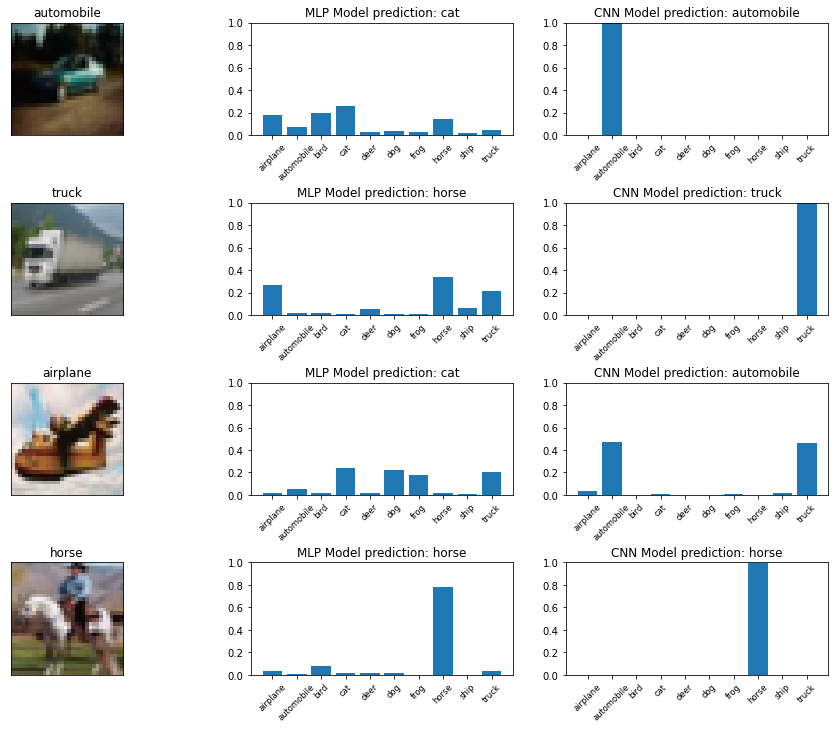

In [44]:
preds_1 = MLP_Metrics["40, 0.01"][-1].T
preds_2 = model_3.predict(x_val)
plot_examples(preds_1, preds_2, random_inx)

After repeating this for various samples, it becomes apparent that the CNN model in general seems to be more 'confident' in its prediction, whilst the MLP model dsitributes the probability over more classes.

## Task 2: Unsupervised Learning <a class="anchor" id="t2"></a>
***

We begin this section by loading the feature matrix into a 2D numpy array and processing it accordingly:

In [45]:
# Feature Matrix
F = np.loadtxt(open("data/feature_matrix_karate_club.csv", "rb"), delimiter=",", skiprows=1)
individuals = F[:, 0]
feature_matrix = F[:, 1:]

### 2.1 Clustering of the Feature Matrix <a class="anchor" id="q2_1"></a>
***

#### Question 2.1.1 <a class="anchor" id="2_1_1"></a>
***

First we will be defining some functions for use in the k_means function.

We create the $N \times N$ (where $N$ = 34 samples here) distance matrix from the feature matrix:

In [46]:
def distance_matrix(X):
    difference = X[:, :, None] - X[:, :, None].T
    D = np.sqrt((difference**2).sum(1))
    return D

D = distance_matrix(feature_matrix)

We have a function to construct the $N \times k$ assignment matrix where each row represents a sample data point and each column represents a cluster:

In [47]:
def assignment_matrix(k, labels):
    return np.eye(k)[labels]

Next a function to return the average within cluster distance $W(\mathcal{C})$ given the distance matrix and assignment matrix.

The formula used here is obtained from the lecture notes:
$$ W(\mathcal{C}) = \frac{1}{2} \mathrm{Tr} [ (H^T H)^{-1} [H_{k \times N}^T D_{N \times N} H_{N \times k} ] ] $$

In [48]:
def within_cluster(H, D):
    return np.trace(np.linalg.inv(H.T @ H) @ (H.T @ D @ H))/2

Finally, to avoid problems occuring where a cluster label would have no points, we introduce a function to fix this which randomly selects a cluster with more than one point and then randomly selects a point from that cluster and changing its label:

In [49]:
def no_empty_labels(k, new_labels):
    # Find which clusters are empty
    empty_labels = np.setdiff1d(np.arange(k),new_labels)
    
    # Randomly assign a new element from a random cluster (with size > 1) to this label
    for empty_lab in empty_labels:
        
        # Find clusters with greater than one element in them
        c = collections.Counter(new_labels)
        multiple_element_labels = [j[0] for j in c.items() if j[1] > 1]
        
        # Randomly choose cluster
        rand_lab = np.random.choice(multiple_element_labels)
        
        # Randomly choose element in that cluster and change the label
        idx = np.random.choice(np.where(new_labels == rand_lab)[0])
        new_labels[idx] = empty_lab
        
    return new_labels

Finally we can implement the function that applies the k-means algorithm.

Within this function we also use the functions defined above to calculate the average within-cluster distance and at the end we return both the final labels and this distance metric.

In [50]:
def k_means(X, k, max_iter, print_progress=False):
    n_samples, n_features = X.shape

    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    
    # ensure there are no empty clusters
    labels = no_empty_labels(k, labels)
    
    # computing the centroids of each of the k clusters
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[:-1]
    
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        if print_progress:
            print('Iteration:', i)
        
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)
        
        # Ensure that there are no empty labels
        new_labels = no_empty_labels(k, new_labels)
        
        # Calculate the average within cluster distance
        W = within_cluster(assignment_matrix(k, labels), D)
        
        # Check if the labels are unchanged
        if (labels==new_labels).all():
            labels = new_labels
            break

        else:
            # Calculate the percentage of changed labels
            difference = np.mean(labels!=new_labels)
            
            if print_progress:
                print('%4f%% labels changed' % (difference * 100))
            
            # Update labels and centroids
            labels = new_labels
            for c in range(k):
                if (labels == c).any():
                  centroids[c] = np.mean(X[labels==c], axis=0)
    
    return labels, W

As we want to run the k-means algorithm for 100 different random initialisations, we create a wrapper function that calls the function in a loop and stores each of the 100 labels and 100 within-cluster distances in lists:

In [51]:
def k_means_100(X, k, max_iter, print_progress=False):
    # Create lists to store the clusterings and average within-cluster distances
    label_list = []
    W_list = []
    
    for i in range(100):
        new_label, new_W = k_means(X, k, max_iter, print_progress=print_progress)
        label_list.append(new_label)
        W_list.append(new_W)
    
    return label_list, W_list

Finally we call the above function for values of $k$ in the interval $[2, 10]$, and store the returned lists in a dictionary:

In [52]:
# Create a dictionary to store all the scores and cluster labels obtained
k_means_all = {}

for k in range(2, 11):
    print("Loop k = " + str(k))
    k_means_all[k] = k_means_100(feature_matrix, k, 50)

Loop k = 2
Loop k = 3
Loop k = 4
Loop k = 5
Loop k = 6
Loop k = 7
Loop k = 8
Loop k = 9
Loop k = 10


We then find the optimised clustering for each k by choosing the one that minimises the average within-cluster distance $W(\mathcal{C})$, and we store the minimal distance for each k in a list for plotting:

In [53]:
optimal_idx = {}
optimal_W = []
for k in range(2, 11):
    # get the index of the optimal cluster
    optimal_idx[k] = np.argmin(k_means_all[k][1])
    # add the optimal W(C) to the list
    optimal_W.append(k_means_all[k][1][optimal_idx[k]])

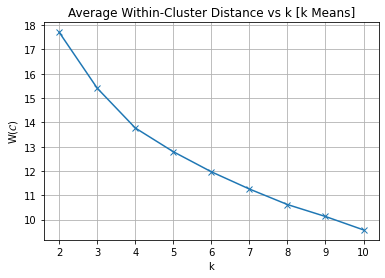

In [54]:
# plot the optimal average within-cluster distances
plt.plot(range(2, 11), optimal_W, '-x')
plt.title("Average Within-Cluster Distance vs k [k Means]")
plt.xlabel("k")
plt.ylabel("W($\mathcal{C}$)")
plt.grid()
plt.show()

First we note that we chose the optimal clustering for each k based on the clustering that produced the minimum W($\mathcal{C}$ metric. This is because the objective of k-means is to minimise this distance whcih also maximises the between distance for the clusters as discussed in lectures.

The reason we run do 100 random initialisations is because this is a non-convex optimisation problem, so we cannot guarantee a global minimum, only a local one.

In order to select an optimal $k$ value, we can examine the graph above and we would like to choose the smallest k that produces a small $W(\mathcal{C})$. Thus the 'elbow' method is often used where we choose the $k$ corresponding to the 'elbow' of the curve above where increasing $k$ above this value does not lead to significant reduction in $W(\mathcal{C})$.

Although the elbow is not obvious from this particular graph, the most apparent change in gradient seems to be at $k = 4$, and so could this could be one choice for the optimal $k$.

#### Question 2.1.2 <a class="anchor" id="2_1_2"></a>
***

For the Calinski-Harabasz (CH) score, I will be using this formula:
$$ CH = \frac{{SS}_B}{{SS}_W} \times \frac{N-k}{k-1} $$

where ${SS}_B$ = total between-cluster variance, ${SS}_W$ = total within-cluster variance, $N$ = number of samples, $k$ = number of clusters.

Further, ${SS}_B := \sum \limits_{i=1}^k n_i \lVert{m_i - m}\rVert^2 $ and ${SS}_W := \sum\limits_{i=1}^k \sum \limits_{x \in c_i} \lVert{x - m_i}\rVert^2 $\
where $m$ is the overall centroid, $m_i$ is the centroid of cluster $i$, and the norm used is the $L^2$ norm.

[This formula is obtained from: https://in.mathworks.com/help/stats/clustering.evaluation.calinskiharabaszevaluation-class.html#bt0y0hg-8
]

Also, we can calculate ${SS}_B$ by calculating the total sum of squares and subtracting the total within-cluster variance from it.

$$ {SS}_B = TSS - {SS}_W, \qquad \textrm{where} \quad TSS = \sum\limits_{i=1}^k \sum \limits_{x \in c_i} \lVert{x - m}\rVert^2 $$

[This result is obtained from: https://www.webpages.uidaho.edu/~chrisw/stat401live/anova1.pdf ]

So we can now create functions to find $TSS$ and ${SS}_W$ and another one to obtain the CH score using these:

In [55]:
def total_sum_squares(X):
    centroid = np.mean(X, axis=0, keepdims=True)
    tss = np.sum(np.square(np.linalg.norm(X - centroid, axis = 1)))
    
    return tss

def within_sum_squares(X, labels):
    k = len(np.unique(labels))
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    
    ssw = 0
    
    for i in range(k):
        # Find all the elements in cluster k
        cluster_elements = np.array([x for x in X_labels if x[-1]==i])[:,:-1]
        
        # Calculate the within cluster total sum of squares and add it to the total
        ssw += total_sum_squares(cluster_elements)
    
    return ssw

def CH_score(X, labels):
    k = len(np.unique(labels))
    N = X.shape[0]
    
    # Within sum of squares
    ssw = within_sum_squares(X, labels)
    
    # Between sum of squares
    ssb = total_sum_squares(X) - ssw
    
    # CH score
    score = ssb / ssw * (N - k) / (k - 1)
    
    return score

Now we can use the dictionary above which stored all the labels from the 900 runs of the k-means algorithm, and calculate the CH_score for each one and store them in a dictionary:

In [56]:
CH_scores = {}

# 9 iterations
for k in range(2, 11):
    label_list, _ = k_means_all[k]
    CH_scores[k] = []
        
    # 100 iterations
    for labels in label_list:
        CH_scores[k].append(CH_score(feature_matrix, labels))

Finally we can obtain the average CH score over the 100 random intialisations for each k, and plot them below:

In [57]:
average_CH_scores = []
for k in range(2, 11):
    average_CH_scores.append(np.mean(CH_scores[k]))

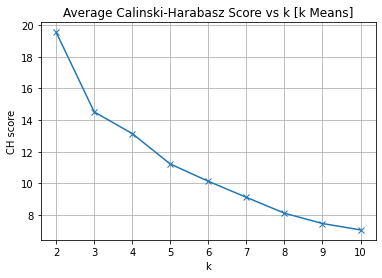

In [58]:
plt.plot(range(2, 11), average_CH_scores, '-x')
plt.title("Average Calinski-Harabasz Score vs k [k Means]")
plt.xlabel("k")
plt.ylabel("CH score")
plt.grid()
plt.show()

As we see in the formula, the CH score is a ration of the within-cluster and between-cluster variabilities, so this score tells us how the clusters a balanced.

The CH score will be higher the more the concentrated and well-separated clusters are, which is what we are aiming for.\
Thus judging from this graph, the optimal clustering would be to use $k = 2$.

#### Question 2.1.3 <a class="anchor" id="2_1_3"></a>
***

In order to get a measure of the robustness of the clusterings, we can use the $W(C)$ distances and the CH scores obtained from the random initialisations above.

First we arrange all the 900 distances and scores into $9 \times 100$ numpy arrays:

In [59]:
# We have 100 CH scores and 100 W(C) values for each k
W_matrix = np.zeros((9, 100))
CH_matrix = np.zeros((9, 100))
for k in range(2, 11):
    W_matrix[k-2, :] = k_means_all[k][1]
    CH_matrix[k-2, :] = CH_scores[k]

One way to measure how consistent / variable the clusters for each $k$ are is to examine the variances of the two metrics for each $k$.

However we can notice that the magnitudes of the $W(C)$ and the CH score varies for each k, so we can use the relative variance instead, where we divide by the absolute value of the mean of the groups. In this way we can account for scale differences.

We compute and plot these relative variances below:

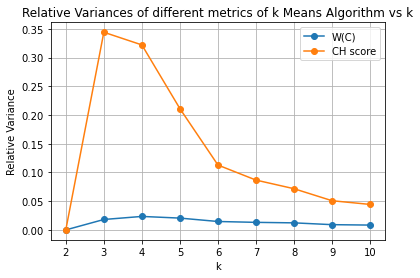

In [60]:
# Compute the RELATIVE variances of each of the metrics for a fixed k
W_rel_variance = np.var(W_matrix, axis=1) / np.mean(W_matrix, axis=1)
CH_rel_variance = np.var(CH_matrix, axis=1) / np.mean(CH_matrix, axis=1)

# Plot them
plt.plot(range(2, 11), W_rel_variance, '-o', label='W(C)')
plt.plot(range(2, 11), CH_rel_variance, '-o', label='CH score')
plt.title("Relative Variances of different metrics of k Means Algorithm vs k")
plt.legend()
plt.xlabel("k")
plt.ylabel("Relative Variance")
plt.grid()
plt.show()
plt.show()

If the relative variance for a group is smaller, this means that clusterings of each of the 100 random initialisations for this group are more similar. Hence a smaller relative variance for a particular $k$ means that that clustering is more robuts.

Here it appears that the most robust clusterings are when $k=2$ for both metrics.

This becomes even more apparent when we plot relative variance on a log scale:

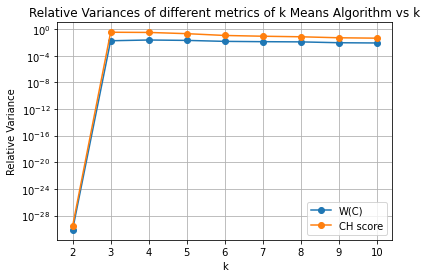

In [61]:
plt.semilogy(range(2, 11), W_rel_variance, '-o', label='W(C)')
plt.semilogy(range(2, 11), CH_rel_variance, '-o', label='CH score')
plt.title("Relative Variances of different metrics of k Means Algorithm vs k")
plt.legend()
plt.xlabel("k")
plt.ylabel("Relative Variance")
plt.grid()
plt.show()
plt.show()

Thus based on this graph and the $W(\mathcal{C})$ and CH graphs above we can take $k=2$ to be a good optimal value for k, and then find the optimal clustering of the 100 random intialisations for $k=2$ and select that as the optimal clustering.

However it should be noted that metrics that measure how well defined clusters are such as the "Silhouette Coefficient" and other scores to measure similarity between clusters such as the "Adjusted Rand Score" which we could also use to determine the optimal $k$.

In order to get a quick and simple visualisation of this clustering, we can use the obtain the labels and then 3D scatter plot the 34 datapoints with 3 example features.


Here we use the features 1, 2 and 100:

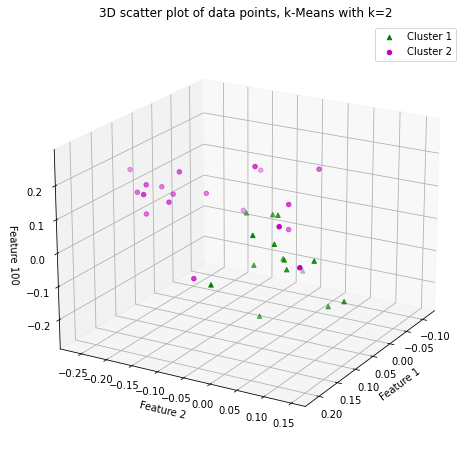

In [62]:
optimal_label = k_means_all[2][0][optimal_idx[2]]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig) 

x = feature_matrix[:,0]
y = feature_matrix[:,1]
z = feature_matrix[:,-1]

index_0 = np.where(optimal_label == 0)
index_1 = np.where(optimal_label == 1)

ax.set_title("3D scatter plot of data points, k-Means with k=2")
ax.scatter(x[index_0], y[index_0], z[index_0], color = 'g', marker='^', label='Cluster 1')
ax.scatter(x[index_1], y[index_1], z[index_1], color = 'm', marker='o', label='Cluster 2')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 100')
ax.view_init(20, 30)
plt.legend()
plt.show()

However of course, just these three features are not representative, and the clustering is obtained from using all the 100 features of the dataset.

### 2.2 Dimensionality Reduction of the Feature Matrix <a class="anchor" id="q2_2"></a>
***

#### Question 2.2.1 <a class="anchor" id="2_2_1"></a>
***

First we normalise the data in the feature matrix so that each column has a mean of zero and variance of one:

In [63]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

normalized_feature_matrix = normalize(feature_matrix)

Next we define our function that performs Principal Component Analysis (PCA) given a matrix X and a dimension k:

In [64]:
def pca_function(X, k):
    n = X.shape[0]

    # create covariance matrix S
    C = X.T @ X / (n-1)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

Now we apply the PCA function for all d in range $[1, 10]$ and store the results in a dictionary:

In [65]:
PCA_info = {}
for d in range(1, 11):
    print("Loop d = " + str(d))
    PCA_info[d] = pca_function(normalized_feature_matrix, d)

Loop d = 1
Loop d = 2
Loop d = 3
Loop d = 4
Loop d = 5
Loop d = 6
Loop d = 7
Loop d = 8
Loop d = 9
Loop d = 10


Now we can create a function to plot the dataset given the X_pca output matrix from the function above:

In [66]:
def PCA_plotter(X_pca_1, X_pca_2, X_pca_3, labels = None):
    fig = plt.figure(figsize=(15, 4))
    ax0 = fig.add_subplot(1, 3, 1)
    ax1 = fig.add_subplot(1, 3, 2)
    ax2 = fig.add_subplot(1, 3, 3, projection='3d')
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    
    # 1D plot for d = 1
    ax0.scatter(X_pca_1.T, np.zeros(34), marker='x', c=labels)
    ax0.set_title("Projection onto 1-D PCA space")
    ax0.set_xlabel("PCA Dimension 1")
    ax0.axes.yaxis.set_visible(False)
    
    # 2D plot for d = 2
    ax1.scatter(X_pca_2[:,0], X_pca_2[:,1], marker='o', c=labels)
    ax1.set_title("Projection onto 2-D PCA space")
    ax1.set_xlabel("PCA Dimension 1")
    ax1.set_ylabel("PCA Dimension 2")
    
    # 3D plot for d = 3
    ax2.set_title("Projection onto 3-D PCA space")
    ax2.scatter(X_pca_3[:,0], X_pca_3[:,1], X_pca_3[:,2], marker='o', c=labels)
    ax2.set_xlabel("PCA Dimension 1")
    ax2.set_ylabel("PCA Dimension 2")
    ax2.set_zlabel("PCA Dimension 3")
    ax2.view_init(25, 25) 
    plt.show()

Now we can produce the plots:

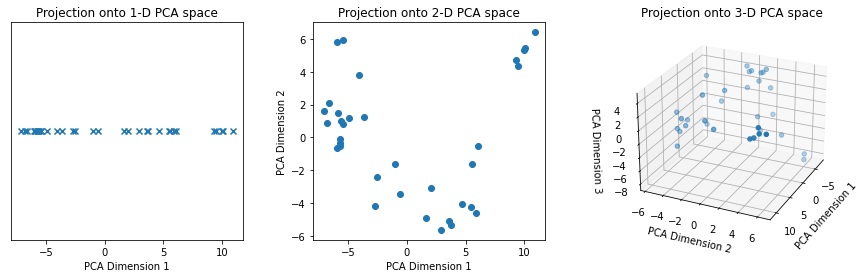

In [67]:
PCA_plotter(PCA_info[1][0], PCA_info[2][0], PCA_info[3][0])

Firstly we can already observe that even in a 2D projection onto the PCA space, patterns and apparent groups of data start to appear. 

In the first plot we can see 3 groups of data close to eatchother and also in the second plot. Further the datapoints in the projection onto 2D space seem to follow a quadratic curve shape, which suggests we have captured some important features of the dataset in only these two principal components.

This suggests that the two principal components for d = 2 provide a good description of the data and indeed could be the ones that describe the clustering groups from 2.1.

In order to check this, we can use the optimal clustering obtained in 2.1 and replot the graphs showing the labels of this cluster:

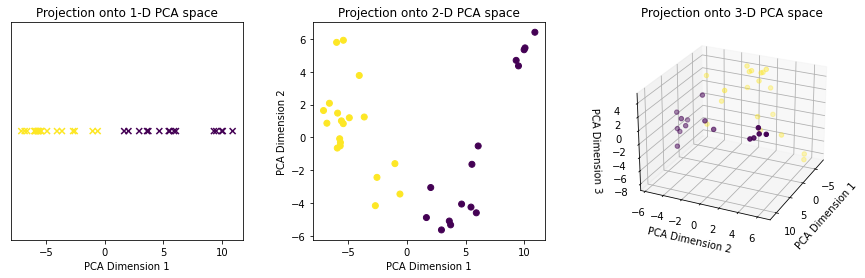

In [68]:
PCA_plotter(PCA_info[1][0], PCA_info[2][0], PCA_info[3][0], labels = optimal_label)

We notice that the two clusters of the optimal clustering are very clearly separated and identified in these three PCA spaces.

#### Question 2.2.2 <a class="anchor" id="2_2_2"></a>
***

We first compute the total variance by constructing the sample covariance matrix and taking absolute value of the sum of its eigenvalues.

Then we use this to compute the explained variances for each d and store them in a dictionary:

In [69]:
# Compute total variance
C = 1.0/(len(normalized_feature_matrix)-1) * np.dot(normalized_feature_matrix.T, normalized_feature_matrix)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

# Compute explained variances
explained_variances = {}
for d in range(1, 11):
    e_values = PCA_info[d][2]
    explained_variances[d] = e_values /  total_variance

We notice that the list of explained variances stays the same from d to d+1, with an extra value appended at the end: 

In [70]:
explained_variances

{1: array([0.35064983]),
 2: array([0.35064983, 0.13343093]),
 3: array([0.35064983, 0.13343093, 0.11060028]),
 4: array([0.35064983, 0.13343093, 0.11060028, 0.05794571]),
 5: array([0.35064983, 0.13343093, 0.11060028, 0.05794571, 0.04966434]),
 6: array([0.35064983, 0.13343093, 0.11060028, 0.05794571, 0.04966434,
        0.03994313]),
 7: array([0.35064983, 0.13343093, 0.11060028, 0.05794571, 0.04966434,
        0.03994313, 0.03365556]),
 8: array([0.35064983, 0.13343093, 0.11060028, 0.05794571, 0.04966434,
        0.03994313, 0.03365556, 0.03159395]),
 9: array([0.35064983, 0.13343093, 0.11060028, 0.05794571, 0.04966434,
        0.03994313, 0.03365556, 0.03159395, 0.0288543 ]),
 10: array([0.35064983, 0.13343093, 0.11060028, 0.05794571, 0.04966434,
        0.03994313, 0.03365556, 0.03159395, 0.0288543 , 0.02761302])}

This makes sense as during PCA we take d eigenvectors corresponding to the largest d eigenvalues (in decreasing order). So the first d principal compenents will be the same for PCA with d dimensions and PCA with d+1 dimensions.

We also plot these proportions:

Now we plot these proportions:

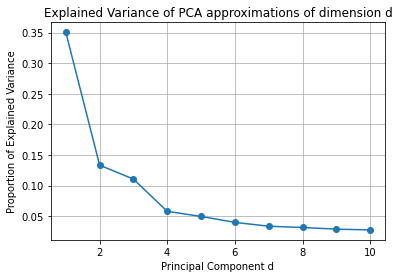

In [71]:
plt.plot(range(1, 11), explained_variances[10], marker='o')
plt.title("Explained Variance of PCA approximations of dimension d")
plt.xlabel("Principal Component d")
plt.ylabel("Proportion of Explained Variance")
plt.grid()
plt.show()

As we normalised the feature matrix, we have that $\mathcal{F} := F - \frac{1}{N} \mathbf{1} \mathbf{1}^T F = F $, where $F$ is the feature matrix and $N$ is the number of samples.

And hence  $F^T F$ gives us a scaled version of the covariance matrix $C_\mathrm{x}$.

So the eigenvectors of $F^T F$ are the same as the those of $C_\mathrm{x}$ which are the basis used in PCA.
Furthermore as they are just scaled versions of eachother, the eigenvalues will also be scaled similarly.

Thus when taking the spectral decomposition of $F^T F$, the eigenvalues are just scaled versions of the variances of the components from PCA.

We can find these eigenvalues, rescale them so that their sum is 1, and plot their cumulative sum:

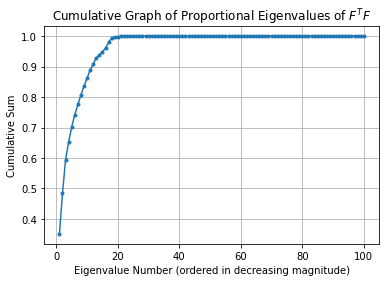

In [72]:
F = normalized_feature_matrix
all_e_vals, all_e_vecs = np.linalg.eig(F.T @ F)
plt.plot(range(1, 101),(abs(np.cumsum(all_e_vals)) / abs(all_e_vals.sum()))[:100], marker='.')
plt.title("Cumulative Graph of Proportional Eigenvalues of $F^T F$")
plt.xlabel("Eigenvalue Number (ordered in decreasing magnitude)")
plt.ylabel("Cumulative Sum")
plt.grid()
plt.show()

To get a better idea, we can just examine the first 20 eigenvalues instead:

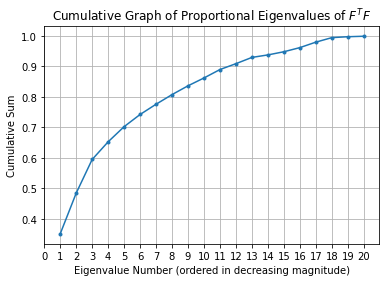

In [73]:
plt.plot(range(1, 21),(abs(np.cumsum(all_e_vals)) / abs(all_e_vals.sum()))[:20], marker='.')
plt.title("Cumulative Graph of Proportional Eigenvalues of $F^T F$")
plt.xlabel("Eigenvalue Number (ordered in decreasing magnitude)")
plt.ylabel("Cumulative Sum")
plt.gca().set_xticks(np.arange(0,21))
plt.grid()
plt.show()    

As explained above this cumulative sum represents a cumulative proportion of explained variance for the prinipcal components in PCA.

So we see that just the first 2 components contain approximately 50% of the variance and only the first 12 components are needed to describe over 90% of the variance of the dataset.

Thus this does indeed suggest that the dataset is very well described in reduced dimensions, and supports the range of $k$ values we used to examine possible clusterings in the k-Means section in 2.1.

### 2.3 Graph-Based Analysis <a class="anchor" id="q2_3"></a>
***

#### Question 2.3.1 <a class="anchor" id="2_3_1"></a>
***

We load in and process the required data for this section:

In [74]:
# Adjacency Matrix
A = np.loadtxt(open("data/karate_club_graph.csv", "rb"), delimiter=",", skiprows=1)
adjacency_matrix = A[:, 1:]

# Ground Truth
S = list(csv.reader(open("data/ground_truth_karate_club.csv")))
true_split = S[1:]

# Convert to Ground Truth to numpy array with "Mr Hi" being 0 and "Officer" being 1
true_split_np = np.vstack((np.arange(34), np.zeros(34))).T
for i in range(34):
    if true_split[i][1] == "Officer":
        true_split_np[i, 1] = 1

First we create three functions to compute the three measures of centrality given an adjacency matrix $A$.

The formulas for centrality used here are:

* Degree Centrality: $\mathbf{c}_d = \frac{\mathbf{d}}{2E}$ \
where $\mathbf{d}$ is the degree of the node, and $E$ is the total number of edges of the graph.


* PageRank Centrality: The PageRank centrality of each node is the corresponding element of $\mathbf{C}_{PR}$ where $\mathbf{C}_{PR}$ is the stationary eigenvector of the equation: 
$$\mathbf{C}_{PR} = \alpha (AD^{-1}) \mathbf{C}_{PR} + (1 - \alpha) \frac{1}{N}$$
where $D$ is the degree matrix, $N$ is the total number of nodes and $\alpha$ is a preset teleportation parameter.


* Eigenvector Centrality: The eigenvector centrality of a node is the corresponding element of the leading eigenvector of $A$.

In [75]:
def degree_cent(A):
    # compute degrees from the adjacency matrix
    degree = A.sum(axis=1)
    
    # compute the total number of edges
    e = np.sum(A) / 2
    
    # divide degree by 2E to get the centrality
    return degree / (2 * e)

def pagerank_cent(A):
    # compute the inverse of the degree matrix
    Dinv = np.diag(np.reciprocal(A.sum(axis=1)))
    
    # number of nodes
    N = A.shape[0]
    
    # set the teleportation parameter to the customary value
    alpha = 0.85
        
    # randomly initialise the vector c_pr
    c_pr = np.random.randn(N)
    
    # compute the page rank centrality via the power iteration method
    max_iterations = 100
    for i in range(max_iterations):
        old_c_pr = c_pr
        c_pr = alpha * A @ Dinv @ old_c_pr + (1 - alpha) / N
        
        # check for convergence
        if np.linalg.norm(c_pr - old_c_pr) < 1e-9:
            break
    
    return c_pr

def eigenvector_cent(A):
    # compute the eigenvector associated with the largest eigenvalue
    eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True)
    
    # sometimes scipy returns negative eigenvector instead, so change sign accordingly
    if eigenvector[0][0] < 0:
        eigenvector = -1 * eigenvector

    return eigenvector.T[0]

Next we apply them to the karate club graph and report the values:

In [76]:
c_pagerank = pagerank_cent(adjacency_matrix)
c_degree = degree_cent(adjacency_matrix)
c_eigenvec = eigenvector_cent(adjacency_matrix)

# Report the values of the centralities
centralities_comparison = pd.DataFrame(index = ["Node " + str(i) for i in range(1, 35)],
                                       columns = ["PageRank", "Degree", "Eigenvector"],
                                       data = np.vstack((c_pagerank, c_degree, c_eigenvec)).T)
centralities_comparison

,PageRank,Degree,Eigenvector
Node 1,0.096997,0.102564,0.355491
Node 2,0.052877,0.057692,0.265960
Node 3,0.057079,0.064103,0.317193
Node 4,0.035860,0.038462,0.211180
Node 5,0.021978,0.019231,0.075969
Node 6,0.029111,0.025641,0.079483
Node 7,0.029111,0.025641,0.079483
Node 8,0.024491,0.025641,0.170960
Node 9,0.029766,0.032051,0.227404
Node 10,0.014309,0.012821,0.102674


Next we standardise the centralities so that we can plot and compare them on one graph. \
We standardise them by scaling each centrality measure so that the sum of centralities with that measure for all the nodes is 1.

Note the pagerank and degree centralities are already scaled in this way so standardising them have no effect.

We then plot them all on one graph for comparison:

Checking the sum of standardised centrality measures:
1.00000
1.00000
1.00000


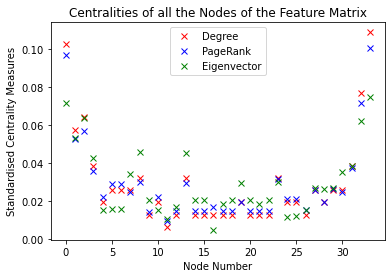

In [77]:
scaled_c_eigenvec = c_eigenvec / np.sum(c_eigenvec)
print("Checking the sum of standardised centrality measures:")
print("%.5f" % np.sum(c_pagerank))
print("%.5f" % np.sum(c_degree))
print("%.5f" % np.sum(scaled_c_eigenvec))

plt.plot(range(34), c_degree, 'rx', label = "Degree")
plt.plot(range(34), c_pagerank, 'bx', label = "PageRank")
plt.plot(range(34), c_eigenvec / np.sum(c_eigenvec), 'gx', label = "Eigenvector")
plt.xlabel("Node Number")
plt.ylabel("Standardised Centrality Measures")
plt.legend()
plt.title("Centralities of all the Nodes of the Feature Matrix")
plt.show()

From this plot we can see that the first few and the last few nodes are seen as highly central compared to the others.\
And in particular the first and last nodes (Node 0 and Node 33) are the two most central nodes for each of the three centrality measures.

We can also obtain a ranking of the nodes for each measure and compare them:

In [78]:
# Rank in decreasing order
pagerank_ranking = np.argsort(-1 * c_pagerank)
degree_ranking = np.argsort(-1 * c_degree)
eigenvec_ranking = np.argsort(-1 * c_eigenvec)

# Report the rankings
sorted_centralities = pd.DataFrame(index = ["PageRank", "Degree", "Eigenvector"],
                                   columns = ["Highest Centrality"] + [" " for i in range(32)] + ["Lowest Centrality"],
                                   data=np.vstack((pagerank_ranking, 
                                                   degree_ranking, 
                                                   eigenvec_ranking)))
sorted_centralities

,Highest Centrality,,,,,,,,,,...,,,,,,,,,,Lowest Centrality
PageRank,33,0,32,2,1,31,3,23,8,13,...,12,21,17,20,18,15,14,22,9,11
Degree,33,0,32,2,1,3,31,13,23,8,...,21,20,18,15,14,12,9,22,16,11
Eigenvector,33,0,2,32,1,8,13,3,31,30,...,12,6,5,4,10,26,25,24,11,16


From this we see further that the top 5 most central nodes for each centrality measure comprise of the set of elements (33, 0, 32, 2, 1).

We can also create a correlation matrix of the three centrality measures and plot the heatmap of this matrix:

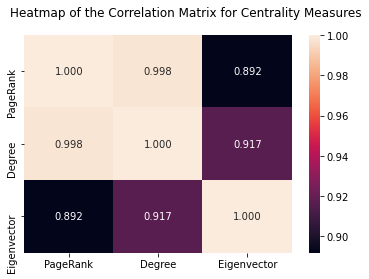

In [79]:
sns.heatmap(centralities_comparison.corr(), annot=True, fmt='.3f')
plt.suptitle("Heatmap of the Correlation Matrix for Centrality Measures")
plt.show()

Thus we see that PageRank and Degree centralities are very highly correlated, with the correlation coefficient being almost 1.

The Eigenvector centrality is still highly correlated with the other two centralities, but not as highly as the first two.

To observe this we can produce pair plots with to visually see the how strong the correlations are:

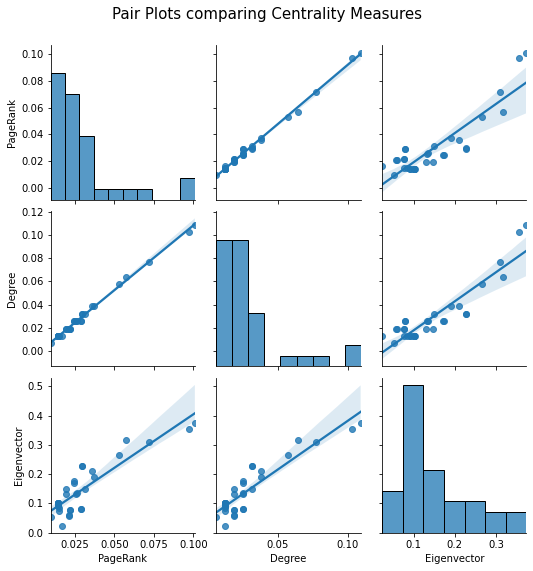

In [80]:
fig = sns.pairplot(centralities_comparison, kind='reg')
plt.suptitle("Pair Plots comparing Centrality Measures",fontsize=15, y=1.05)
plt.show()

As we saw with the centrality rankings, the order of the nodes differ for each ranking. This is because each centrality measure performs a different role and assigns importance to particular nodes based on different measures.

For example with Degree centrality, a node has a higher centrality the more connections / edges it has.\
Eigenvector centrality assigns higher centrality to nodes that are themselves connected to other highly central nodes. \
PageRank works in a similar way to Eigenvector in that a node is also affected by the centrality of nodes linked to it, however it has a probabilistic aspect built in to it.

#### Question 2.3.2 <a class="anchor" id="2_3_2"></a>
***

We use the NetworkX module to create a graph from the adjacency matrix.\
Then we apply the Clauset-Newman-Moore greedy modularity maximisation algorithm to report the optimal clustering and partitions:

In [81]:
G = nx.from_numpy_array(adjacency_matrix)
communities = list(nx.algorithms.community.greedy_modularity_communities(G))

optimal_k_star = len(communities)
partition = [sorted(communities[i]) for i in range(3)]

print("The optimal number of communities is: " + str(optimal_k_star) + "\n")

for i in range(optimal_k_star):
    print("Nodes in Community " + str(i+1) + " are: " + str(partition[i]))

The optimal number of communities is: 3

Nodes in Community 1 are: [8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Nodes in Community 2 are: [1, 2, 3, 7, 9, 12, 13, 17, 21]
Nodes in Community 3 are: [0, 4, 5, 6, 10, 11, 16, 19]


Next we plot the obtained clusters on the graph assigning different colours to nodes corresponding to different communities:

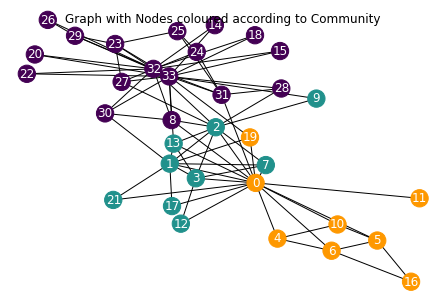

In [82]:
# Create a list of labels corresponding to the community of each node
node_community_id = []
for label in list(G.nodes()):
    for k in range(optimal_k_star):
        if label in partition[k]:
            col = k
            node_community_id.append(col)
            break

# Create a colour map for visualising the clusters
cmap = plt.cm.viridis(np.linspace(0,1,3))
cmap[-1, :] = np.array([255/256, 153/256, 0, 1])
cmap = mpl_colors.ListedColormap(cmap[:, :-1])

# Use NetworkX to plot the obtained clusters on the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=node_community_id, with_labels = True, cmap=cmap, font_color='w')
plt.suptitle("Graph with Nodes coloured according to Community")
plt.show()

Next we find the distribution of the top 8 most central nodes across the 3 communities according to different centrality measures:

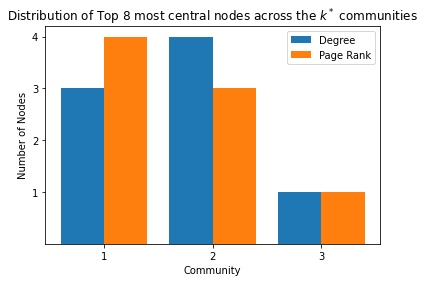

In [83]:
# Find the which nodes in each community are in the set of the top 8 most central nodes
degree_dist = []
pagerank_dist = []
for i in range(3):
    degree_dist.append([node for node in degree_ranking[:8] if node in partition[i]])
    pagerank_dist.append([node for node in pagerank_ranking[:8] if node in partition[i]])

# Plot the distributions
plt.bar(np.arange(1, 4) - 0.2, [len(degree_dist[i]) for i in range(3)], 0.4, label = "Degree")
plt.bar(np.arange(1, 4) + 0.2, [len(pagerank_dist[i]) for i in range(3)], label = "Page Rank", width=0.4)
plt.xlabel("Community")
plt.ylabel("Number of Nodes")
plt.xticks(np.arange(1, 4))
plt.yticks(np.arange(1, 5))
plt.legend()
plt.title("Distribution of Top 8 most central nodes across the $k^*$ communities")
plt.show()

We see that the distributions of the number of top 8 most central nodes are almost identical for the two centrality measures compared.\
This makes sense as PageRank and Degree centralities both involve ideas of how "connected" a node is to other nodes as explained above, however they are not exactly the same as PageRank also takes into account the "connectedness" of the nodes it is connected to.

We can also plot graphs with the size of nodes changing according to the centrality measures.

We observe that for this dataset they appear almost identical when just visually comparing them:

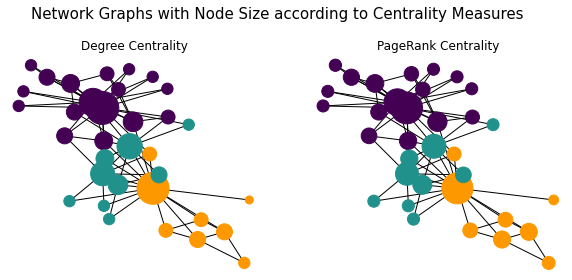

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.flatten()

# Change size of nodes according to Degree Centrality
nx.draw(G, pos, node_size = c_degree*10000, node_color=node_community_id,
        cmap=cmap, font_color='w', ax=ax[0])
ax[0].title.set_text('Degree Centrality')

# Change size of nodes according to PageRank Centrality
nx.draw(G, pos, node_size = c_pagerank*10000, node_color=node_community_id,
        cmap=cmap, font_color='w', ax=ax[1])
ax[1].title.set_text('PageRank Centrality')

plt.suptitle('Network Graphs with Node Size according to Centrality Measures', y=1.05, fontsize=15)
plt.show()

#### Question 2.3.3 <a class="anchor" id="2_3_3"></a>
***

First we reobtain the the two clusterings that we want to compare as well as the real life split (ground truth):

In [85]:
# from 2.1.2
optimal_labels_1 = optimal_label

# from 2.3.2
optimal_labels_2 = np.array(node_community_id)

# from the uploaded csv data
ground_truth = true_split_np[:, 1]

We start by creating a function to produce the contingency table as a 2D numpy array:
$$
\begin{array}{c|cccc|c}
{{} \atop X}\!\diagdown\!^Y &
Y_1&
Y_2&
\cdots&
Y_s&
\text{sums}
\\
\hline
X_1&
n_{11}&
n_{12}&
\cdots&
n_{1s}&
a_1
\\
X_2&
n_{21}&
n_{22}&
\cdots&
n_{2s}&
a_2
\\
\vdots&
\vdots&
\vdots&
\ddots&
\vdots&
\vdots
\\
X_r&
n_{r1}&
n_{r2}&
\cdots&
n_{rs}&
a_r
\\
\hline
\text{sums}&
b_1&
b_2&
\cdots&
b_s&
\end{array}
$$
where $X = \{X_1, X_2, ..., X_r\}$ and $Y = \{Y_1, Y_2, ..., Y_s\}$ are two clusterings, and $n_{ij}$ is the number of nodes in common between $X_i$ and $Y_j$

In [86]:
def contingency_table(X, Y):
    # Find the number of clusters in each clustering array
    r = len(np.unique(X))
    s = len(np.unique(Y))
    contingency_mat = np.zeros((r, s))
    
    for i in range(r):
        # Cluster i of X
        X_i = np.where(X == i)[0]
        
        for j in range(s):
            # Cluster j of Y
            Y_j = np.where(Y == j)[0]
            
            # Find the number of common elements in each cluster
            contingency_mat[i, j] = len(np.intersect1d(X_i, Y_j))
            
    return contingency_mat

Next we define a function to compute $n \choose 2$ for a given $n$:

In [87]:
def nChoose2(n):
    if n < 2:
        return 0

    numerator = np.math.factorial(n)
    denominator = np.math.factorial(n-2) * 2
    return numerator / denominator

Finally we can create the function to return the Adjusted Rand Index (ARI) given two different clusterings.

The formula we use here is: 
$
\frac{\left. \sum_{ij} \binom{n_{ij}}{2} - \left[\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}\right] \right/ \binom{n}{2} }{ \left. \frac{1}{2} \left[\sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}\right] - \left[\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}\right] \right/ \binom{n}{2}}
$

In [88]:
def ARI_score(labels_1, labels_2):
    # Get the contingency table
    C_T = contingency_table(labels_1, labels_2)
    
    r, s = C_T.shape
    
    # Compute row, column and total sums
    a = np.sum(C_T, axis = 1)
    b = np.sum(C_T, axis = 0)
    n = np.sum(a)
    
    # Initialise variables
    sum_n_ij = 0
    sum_a_i = 0
    sum_b_j = 0
    
    # Compute required quantities by looping over the rows and columns of the contingency table
    for i in range(r):
        for j in range(s):
            sum_n_ij += nChoose2(C_T[i, j])
    
    for i in range(r):
        sum_a_i += nChoose2(a[i])
        
    for j in range(s):
        sum_b_j += nChoose2(b[j])
    
    # Compute the ARI and return
    numerator = sum_n_ij - (sum_a_i * sum_b_j) / nChoose2(n)
    denominator = 0.5 * (sum_a_i + sum_b_j) - (sum_a_i * sum_b_j) / nChoose2(n)
    ARI = numerator / denominator
    return ARI

Next we compute the ARI for each pair of clusterings and report them below:

In [89]:
ARI_scores = np.array([ARI_score(optimal_labels_1, optimal_labels_2),
              ARI_score(optimal_labels_1, ground_truth),
              ARI_score(optimal_labels_2, ground_truth)])

# Report the scores
ARI_comparison = pd.DataFrame(ARI_scores,
                              columns = ["ARI score"],
                              index = ["Optimal k-Means vs Optimal Modularity Maximisation",
                                         "Optimal k-Means vs Ground Truth",
                                         "Optimal Modularity Maximisation vs Ground Truth"])
ARI_comparison

,ARI score
Optimal k-Means (2.vs Optimal Modularity Maximisation,-0.031487
Optimal k-Means vs Ground Truth,0.001297
Optimal Modularity Maximisation vs Ground Truth,0.568439


The ARI normalizes the difference of the Rand Index and its expected value under the null hypothesis that two clusterings are sampled randomly. \
The expected value of the index is zero for independent clusterings and maximum of 1 for completely identical clusterings. \
[Source: https://i11www.iti.kit.edu/extra/publications/ww-cco-06.pdf ]

Thus firstly we see that the ARI is negative when comparing the optimal clusterings from 2.1.2 and 2.3.2, which suggests that these two clusterings are not identical at all.

Similarly the ARI for comparing 2.1.2 and the Ground Truth is very close to 0, and so the score is not much better than the expected result for two random clusterings.

However the similarity between the optimal clustering from 2.3.2 (found via the modularity maximisation methods) and the Ground Truth is non-trivial at over 0.5 and suggests there is a significant similarity between these clusterings. 

Hence in this particular example, modularity maximisation might be a better method to predict or model the split of this karate club. \
This makes sense as modularity is a graph based approach which accounts for the connections between nodes (or people) and how connected each person is with the other members of the club.

## End of Coursework